In [37]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

In [38]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)
# 计算data的方差的函数

In [39]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [49]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # 把conf_mult设置为0也即没有confounder
    else:
        conf_mult = 1 # 则conf_mult为1则包含confounder
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err  #计算Y的函数，包含了covariates
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
      
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            # 不加入covariates
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)

# Q1

## 1.1 Simulate DGP
Y=𝜏∗𝑇+𝛽'∗𝑥+𝑒

In [83]:
tau = 2
corr = .5
conf=False
p =3
p0 = 3 # number of covariates used in the DGP
flagX = 1
N = 1000
Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)

In [84]:
data = np.concatenate([Y,T,X],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'X1', 'X2','X3']
data.to_csv('data1.csv')
data

,Y,T,X1,X2,X3
0,6.053106,0.0,0.548854,0.262800,0.439106
1,0.360699,1.0,0.322727,-0.279439,0.851466
2,30.048403,0.0,1.466910,2.246627,1.563913
3,-12.181095,0.0,0.257773,-1.251860,0.333404
4,4.706990,1.0,-1.135090,0.472551,-0.724442
...,...,...,...,...,...
995,0.660703,0.0,1.627225,0.507038,-1.621230
996,2.038299,1.0,-1.251640,0.164589,-0.462007
997,-28.114046,0.0,-2.986201,-2.072811,-1.216698
998,17.864855,1.0,0.949024,1.305229,0.462455


## 1.2 Illustrate DGP with DAG

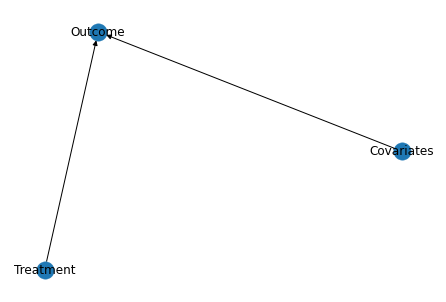

In [56]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Outcome')
G.add_node('s2', desc='Treatment')
G.add_node('s3', desc='Covariates')
G.add_edge('s2','s1')
G.add_edge('s3','s1')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

## 1.3 Monte Carlo experiment

### 1.3.1 Do not control for any covariates

In [85]:
 # not control covariates
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:23<00:00, 84.62it/s] 


In [86]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.008089619047511576, RMSE=3.06938343467151, size=0.055
N=1000: bias=-0.033027797167848046, RMSE=0.97162858199058, size=0.0525


###  1.3.2 Control for all the covariates that affect the outcome

In [87]:
# control covariates
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:36<00:00, 54.19it/s] 


In [88]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.000533942202854898, RMSE=0.1438934526955495, size=0.0575
N=1000: bias=-4.774458707820928e-05, RMSE=0.045638309881947614, size=0.054


## 1.4 Example of a real-life situation
In research of the influence of temperature on precipitation. Y could be precipitation, and temperature could be the teatment. Altitude, latitude & longitude and local humidity could be effecting precipitation, hence they could be covariates.

# Q2

## 2.1 Simulate DGP
y = 𝜏 * 𝑇 + 0.6 * Confounder + e

T = 0.6 * Confounder + u

In [92]:
def fn_generate_data_conf(tau,N,p,corr):

    nvar = p+1 
    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,1].reshape([N,1])     
    T = fn_randomize_treatment(N) 
    err = np.random.normal(0,1,[N,1])
    Yab = tau*T+0.6*C+err
    Tab = 0.6*C+err
    return (Yab,T,C)

In [93]:
tau = 5
p = 10
data2 = fn_generate_data_conf(tau,N,p,corr)
a = pd.DataFrame(data2[0])
b = pd.DataFrame(data2[1])
c = pd.DataFrame(data2[2])


data2=pd.concat([a,b,c],axis=1)
data2.columns = ['Y','T','C']
data2.to_csv('confounder.csv')
data2

,Y,T,C
0,1.813946,0,-0.056112
1,5.375167,1,0.155110
2,0.153189,0,-1.262891
3,3.987705,1,0.131014
4,4.590237,1,-0.659303
...,...,...,...
995,-1.371049,0,-0.061752
996,4.437990,1,0.120230
997,-0.124254,0,-1.087312
998,-1.274010,0,-1.563357


## 2.2 Illustrate DGP with a DAG

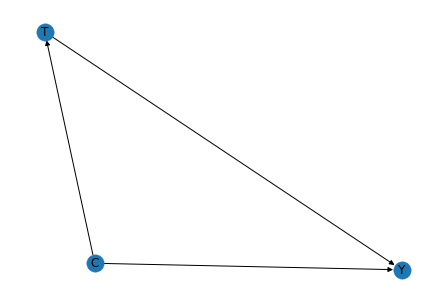

In [94]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Y')
G.add_node('s2', desc='T')
G.add_node('s3', desc='C')
G.add_edge('s2','s1')
G.add_edge('s3','s2')
G.add_edge('s3','s1')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

## 2.3 Monte Carlo experiment

### 2.3.1 Do not control for the confounder

In [95]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:21<00:00, 94.21it/s] 


In [96]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.00243888848282581, RMSE=0.16156815837490932, size=0.058
N=1000: bias=-0.0008057760388566386, RMSE=0.05202525720774329, size=0.0505


### 2.3.2 Control for the confounder

In [97]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T,C],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:17<00:00, 112.08it/s]


In [98]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0019401803231161683, RMSE=0.13845445417864907, size=0.053
N=1000: bias=0.0004912092055761251, RMSE=0.046103844656540105, size=0.061


### 2.4 Example of a real-life situation

If we want to study the effect of whether or not use certain medication will impact the survival rate, we could add one confouder: the severeness of the patient's condition. Because how severe the patient are can affect how to use the medicine, as well as the survival rate of the patient.

# Q3

## 3.1 Simulate DGP

S = 0.8 * Y + 0.8 * T + u

Y = τ* T + e

In [100]:
def fn_generate_data_s(tau,N,p,corr):

    nvar = p+1 # 1 for selection bias
    corr = 0.8 # correlation for multivariate normal
 
    allX = fn_generate_multnorm(N,corr,nvar)
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    U = np.random.normal(0,1,[N,1])
    Y = tau*T+err
    S = 0.8*T+0.8*Y+U

    return (Y,T,S)

In [101]:
tau = 8
corr = 0.8
p = 3
N = 1000
Y,T,S = fn_generate_data_s(tau,N,p,corr)

data = np.concatenate([Y,T,S],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'S']
data.to_csv('data3.csv')
data

,Y,T,S
0,6.834793,1.0,6.782095
1,0.168088,0.0,0.987921
2,-0.049941,0.0,-0.114043
3,0.888429,0.0,-0.158183
4,-1.472146,0.0,-0.938816
...,...,...,...
995,8.154340,1.0,6.172356
996,8.103580,1.0,4.977140
997,7.786704,1.0,6.824767
998,-0.748617,0.0,-0.072838


## 3.2 Illustrate DGP with a DAG

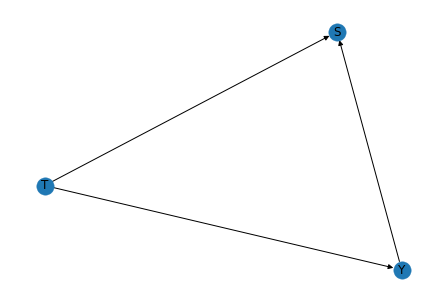

In [102]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Y')
G.add_node('s2', desc='T')
G.add_node('s3', desc='S')
G.add_edge('s2','s1')
G.add_edge('s1','s3')
G.add_edge('s2','s3')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

## 3.3 Monte Carlo experiment

### 3.3.1 Do not control for the variable in between the path from cause to effect

In [109]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data_s(tau,N,p,corr)   
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:11<00:00, 181.31it/s]


In [110]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0033540382612435556, RMSE=0.20038073974956047, size=0.0535
N=1000: bias=0.00040967264685172955, RMSE=0.06591152736701925, size=0.0575


### 3.3.2 Control for the variable in between the path from cause to effect

In [111]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data_s(tau,N,p,corr)
        covars = np.concatenate([T,Z],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:16<00:00, 119.99it/s]


In [112]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-3.5177851672351697, RMSE=3.5481555281621966, size=1.0
N=1000: bias=-3.508284217130617, RMSE=3.5112086313354474, size=1.0


## 3.4 Example of a real-life situation

Assume that I want to investigate whether people with bright personality have stronger willingness to knowledge sharing. And for this purpose I design a questionaire for people to fill out. However, this situation involves three variables: personality, willingness to share knowledge and whether to fill out the questionaire. Personality will affect whether he/she will fill out and willingness to share also affect whether or not to fill out. So personality -> whether fill out the questionaire<- willingness.